# Определение перспективного тарифа для телеком-компании

## Цель исследования

В компании "Мегалайн" существует 2 тарифа:

Тариф «Смарт»:

- Ежемесячная плата: 550 рублей

- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

- минута разговора: 3 рубля

- сообщение: 3 рубля

- 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

- Ежемесячная плата: 1950 рублей

- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

- минута разговора: 1 рубль

- сообщение: 1 рубль

- 1 Гб интернет-трафика: 150 рублей

Главная цель исследования - определить, какой из тарифов приносит больше выручки с пользователей, чтобы выгодно перераспределить рекламный бюджет.

Данное исследование будет состоять из следующих этапов:

1. Обработка данных в датафреймах.

2. Подготовка данных для каждого пользователя за каждый месяц: количество потраченных минут, количество отправленных, количество потраченного интернет-трафика.

3. Подсчет выручки за каждого пользователя за каждый месяц.

4. Анализ статистик каждой услуги (звонки, сообщения, интернет).

5. Проверка гипотез.

6. Вывод.

## Обработка данных в датафреймах

Импортируем необходимые библиотеки.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import math
from datetime import datetime
from matplotlib import pyplot as plt
from scipy import stats as st

Откроем датафреймы с помощью метода `read_csv('')` и запишем их в переменные.

In [2]:
try:
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')

В данном пункте исследования выполним следующие действия:

- Перечислим описание атрибутов из вводных данных к проекту.

- Откроем датафрейм с помощью метода `head()` и сравним атрибуты с описанием к проекту.

- Проанализируем датафрейм с помощью метода `info()` на предмет соответствия типов данных и наличия пропусков.

### Обработка данных в датафрейме calls

Таблица `calls` (информация о звонках) содержит:

- `id` - уникальный номер звонка

- `call_date` - дата звонка

- `duration` - длительность звонка в минутах

- `user_id` - идентификатор пользователя, сделавшего звонок

In [3]:
#  Первые 5 строк датафрейма calls
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


В столбце `duration` длительность звонка указана вплоть до секунд. В описании к заданию сказано, что «Мегалайн» всегда округляет секунды до минут. Поэтому исправим этот нюанс в столбце `duration`, округлив значения до минут в большую сторону.

In [4]:
# Округление секунд до минут
calls['duration'] = np.ceil(calls['duration'])

In [5]:
# Вывод информациии по датафрейму calls
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Изменим тип данных столбца `call_date` с `object` на `datetime`.

In [6]:
# Изменение типа данных на datetime
calls['call_date'] = pd.to_datetime(calls['call_date'])

Пропусков в датафрейме `calls` нет. Проверим датафрейм на дубликаты.

In [7]:
# Проверка на дубликаты
calls.duplicated().sum()

0

### Обработка данных в датафрейме internet

Таблица `internet` (информация об интернет-сессиях) содержит:

- `id` - уникальный номер сессии

- `md_used` - объем потраченного за сессию интернет-трафика (в мегабайтах)

- `session_date` - дата интернет-сессии

- `user_id` - идентификатор пользователя

In [8]:
# Первые 5 строк датафрейма internet
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


В датафрейме есть лишний столбец `Unnamed: 0`. Этот атрибут является дублем индекса, поэтому уберем его из датафрейма.

In [9]:
# Оставляем только нужные атрибуты
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]

In [10]:
# Первые 5 строк датафрейма internet
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [11]:
# Вывод информации по датафрейму internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Изменим тип данных атрибута `session_date` с `object` на `datetime`.

In [12]:
# Изменение типа данных на datetime
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [13]:
# Проверка на дубликаты
internet.duplicated().sum()

0

### Обработка данных в датафрейме messages

Таблица `messages` (информация о сообщениях) содержит:

- id - никальный номер сообщения

- message_date - дата сообщения

- user_id - идентификатор пользователя, отправившего сообщение

In [14]:
# Первые 5 строк датафрейма messages
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [15]:
# Вывод информации по датафрейму messages
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [16]:
# Изменение типа данных на datetime
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [17]:
# Проверка на дубликаты
messages.duplicated().sum()

0

### Обработка данных в датафрейме tariffs

Таблица `tariffs` (информация о тарифах) содержит:

- `tariff_name` - название тарифа

- `rub_monthly_fee` - ежемесячная абонентская плата в рублях

- `minutes_included` - количество минут разговора в месяц, включенных в абонентскую плату

- `messages_included` - количество сообщений в месяц, включенных в абонентскую плату

- `mb_per_month_included` -  объем интернет-трафика, включенного в абонентскую плату

- `rub_per_minute` - стоимость минуты разговора сверх тарифного пакета

- `rub_per_message` - стоимость отправки сообщения сверх тарифного пакета

- `rub_per_gb` - стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета

In [18]:
# Первые 5 строк датафрейма tariffs
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [19]:
# Вывод информации по датафрейму tariffs
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Обработка данных в датафрейме users

Таблица `users` (информация о пользователях) содержит:

- `user_id` - уникальный идентификатор пользователя

- `first_name` - имя пользовтеля

- `last_name` - фамилия пользователя

- `age` - возраст пользователя(годы)

- `reg_date` - дата подключения тарифа (день, месяц, год)

- `churn_date` - дата прекращения пользования тарифом (если значение пропущено, то тариф еще действовал на момент выгрузки данных)

- `city` - город проживания пользователя

- `tariff` - название тарифного плана

In [20]:
# Первые 5 строк датафрейма users
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [21]:
# Вывод информациии по датафрейму tariffs
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [22]:
# Изменение типа данных на datetime
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [23]:
# Проверка на дубликаты
users.duplicated().sum()

0

## Подготовка данных по каждому пользователю за каждый месяц

В данном пункте исследования посчитаем следующие метрики для каждого пользователя:

- Количество израсходованных минут разговора за каждый месяц.

- Количество сделанных звонков за каждый месяц.

- Количество отправленных сообщений за каждый месяц.

- Объем израсходованного интернет-трафика за каждый месяц.

- Выручку за каждый месяц.

Количественные метрики будем считать с помощью сводных таблиц, в которых в качестве индексов будем использовать идентификаторы пользователей, а в качестве столбцов номер месяца. Данные во всех датафреймах представлены только за 2018 год, поэтому путаница с номерами месяцев за разные года не возникнет.

Помесячную выручку посчитаем следующим образом:

1. Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика. Так мы найдем перелимит.

2. Этот перелимит умножим на соответствующую оплату за дополнительные минуту разговора, сообщения или 1 Гб интернет-трафика.

3. Прибавим абонентскую плату, соответствующую тарифному плану пользователя.

### Количество израсходованных минут разговора для каждого пользователя за каждый месяц

Выделим номер месяца из атрибута `call_date` с помощью метода `month` из модуля `dt`.

In [24]:
# Номер месяца из атрибута call_date
calls['call_month'] = calls['call_date'].dt.month

In [25]:
# Проверим корректность создания столбца call_month
calls.head()

,id,call_date,duration,user_id,call_month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [26]:
# Создание сводной таблицы длительности звонков для каждого пользователя помесячно
calls_duration_by_users = calls.pivot_table(index = 'user_id',
                                            columns = 'call_month',
                                            values = 'duration',
                                            aggfunc = 'sum')

In [27]:
# Проверка создания таблицы
calls_duration_by_users

call_month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0
1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0


Для дальнейшего удобства работы с данными сбросим индекс.

In [28]:
# Сбросим индекс
calls_duration_by_users = calls_duration_by_users.reset_index()

In [29]:
calls_duration_by_users

call_month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
2,1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
4,1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0
488,1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0
489,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0
490,1498,NaN,NaN,NaN,NaN,NaN,NaN,175.0,400.0,471.0,247.0,NaN,NaN


Теперь переименуем столбцы сводной таблицы. Это необходимо, чтобы в дальнейшем при подсчете помесячной выручки столбцы имели уникальные названия. 

In [30]:
# Переименование столбцов таблицы calls_duration_by_users
calls_duration_by_users = calls_duration_by_users.rename(columns = {1: '1_call_duration',
                                                                    2: '2_call_duration',
                                                                    3: '3_call_duration',
                                                                    4: '4_call_duration',
                                                                    5: '5_call_duration',
                                                                    6: '6_call_duration',
                                                                    7: '7_call_duration',
                                                                    8: '8_call_duration',
                                                                    9: '9_call_duration',
                                                                    10: '10_call_duration',
                                                                    11: '11_call_duration',
                                                                    12: '12_call_duration'})

In [31]:
calls_duration_by_users

call_month,user_id,1_call_duration,2_call_duration,3_call_duration,4_call_duration,5_call_duration,6_call_duration,7_call_duration,8_call_duration,9_call_duration,10_call_duration,11_call_duration,12_call_duration
0,1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
2,1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
4,1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0
488,1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0
489,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0
490,1498,NaN,NaN,NaN,NaN,NaN,NaN,175.0,400.0,471.0,247.0,NaN,NaN


Сделаем такие же действия для всех остальных пунктов задания.

### Количество отправленных сообщений для каждого пользователя за каждый месяц

In [32]:
# Номер месяца из атрибута message_date
messages['message_month'] = messages['message_date'].dt.month

In [33]:
# Создание сводной таблицы количества отправленных сообщений для каждого пользователя за каждый месяц
messages_count_by_users = (
    messages
    .pivot_table(index = 'user_id',
                      columns = 'message_month',
                      values = 'id',
                      aggfunc = 'count')
    .reset_index()
)

In [34]:
messages_count_by_users

message_month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
3,1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
422,1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
423,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0
424,1498,NaN,NaN,NaN,NaN,NaN,NaN,20.0,62.0,44.0,42.0,NaN,NaN


In [35]:
# Переименование столбцов таблицы messages_count_by_users
messages_count_by_users = messages_count_by_users.rename(columns = {1: '1_messages_count',
                                                                    2: '2_messages_count',
                                                                    3: '3_messages_count',
                                                                    4: '4_messages_count',
                                                                    5: '5_messages_count',
                                                                    6: '6_messages_count',
                                                                    7: '7_messages_count',
                                                                    8: '8_messages_count',
                                                                    9: '9_messages_count',
                                                                    10: '10_messages_count',
                                                                    11: '11_messages_count',
                                                                    12: '12_messages_count'})

In [36]:
messages_count_by_users

message_month,user_id,1_messages_count,2_messages_count,3_messages_count,4_messages_count,5_messages_count,6_messages_count,7_messages_count,8_messages_count,9_messages_count,10_messages_count,11_messages_count,12_messages_count
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
3,1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
422,1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
423,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0
424,1498,NaN,NaN,NaN,NaN,NaN,NaN,20.0,62.0,44.0,42.0,NaN,NaN


### Объем израсходованного интернет-трафика для каждого пользователя за каждый месяц

In [37]:
# Номер месяца из атрибута session_date
internet['session_month'] = internet['session_date'].dt.month

In [38]:
# Создание сводной таблицы объема израсходованного интернет-трафика для каждого пользователя за каждый месяц
internet_by_users = (
    internet
    .pivot_table(index = 'user_id',
                      columns = 'session_month',
                      values = 'mb_used',
                      aggfunc = 'sum')
    .reset_index()
)

In [39]:
internet_by_users

session_month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66
2,1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53
4,1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2614.07,33067.62,29363.00,38939.11,23426.76
493,1496,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15
494,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11500.29,14156.08,19918.60
495,1498,NaN,NaN,NaN,NaN,NaN,NaN,7476.24,24235.21,22134.41,20579.36,NaN,NaN


In [40]:
# Переименование столбцов таблицы internet_by_users
internet_by_users = internet_by_users.rename(columns = {1: '1_mb_sum',
                                                        2: '2_mb_sum',
                                                        3: '3_mb_sum',
                                                        4: '4_mb_sum',
                                                        5: '5_mb_sum',
                                                        6: '6_mb_sum',
                                                        7: '7_mb_sum',
                                                        8: '8_mb_sum',
                                                        9: '9_mb_sum',
                                                        10: '10_mb_sum',
                                                        11: '11_mb_sum',
                                                        12: '12_mb_sum'})

In [41]:
internet_by_users

session_month,user_id,1_mb_sum,2_mb_sum,3_mb_sum,4_mb_sum,5_mb_sum,6_mb_sum,7_mb_sum,8_mb_sum,9_mb_sum,10_mb_sum,11_mb_sum,12_mb_sum
0,1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66
2,1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53
4,1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2614.07,33067.62,29363.00,38939.11,23426.76
493,1496,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15
494,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11500.29,14156.08,19918.60
495,1498,NaN,NaN,NaN,NaN,NaN,NaN,7476.24,24235.21,22134.41,20579.36,NaN,NaN


### Выручка с каждого пользователя за каждый месяц

Для подсчета помесячной выручки с каждого пользователя объеденим все сводные таблицы `calls_duration_by_users`, `messages_count_by_users` и `internet_by_users` в один датафрейм `user_info` с помощью метода `merge`. В качестве способа присоединения выберем `left`, чтобы не потерять часть данных.

In [42]:
# Присоединение таблицы calls_duration_by_users и messages_count_by_users
user_info = calls_duration_by_users[['user_id',
                                     '1_call_duration',
                                     '2_call_duration',
                                     '3_call_duration',
                                     '4_call_duration',
                                     '5_call_duration',
                                     '6_call_duration',
                                     '7_call_duration',
                                     '8_call_duration',
                                     '9_call_duration',
                                     '10_call_duration',
                                     '11_call_duration',
                                     '12_call_duration']].merge(messages_count_by_users[['user_id',
                                                                                         '1_messages_count',
                                                                                         '2_messages_count',
                                                                                         '3_messages_count',
                                                                                         '4_messages_count',
                                                                                         '5_messages_count',
                                                                                         '6_messages_count',
                                                                                         '7_messages_count',
                                                                                         '8_messages_count',
                                                                                         '9_messages_count',
                                                                                         '10_messages_count',
                                                                                         '11_messages_count',
                                                                                         '12_messages_count']],
                                                                how = 'outer',
                                                                on = 'user_id')

In [43]:
# Присоединение таблицы internet_by_users
user_info = user_info.merge(internet_by_users[['user_id',
                                               '1_mb_sum',
                                               '2_mb_sum',
                                               '3_mb_sum',
                                               '4_mb_sum',
                                               '5_mb_sum',
                                               '6_mb_sum',
                                               '7_mb_sum',
                                               '8_mb_sum',
                                               '9_mb_sum',
                                               '10_mb_sum',
                                               '11_mb_sum',
                                               '12_mb_sum']],
                            how = 'outer',
                            on = 'user_id')

In [44]:
# Выведим информацию по итоговой таблице
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 497
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            498 non-null    int64  
 1   1_call_duration    43 non-null     float64
 2   2_call_duration    82 non-null     float64
 3   3_call_duration    114 non-null    float64
 4   4_call_duration    165 non-null    float64
 5   5_call_duration    205 non-null    float64
 6   6_call_duration    244 non-null    float64
 7   7_call_duration    289 non-null    float64
 8   8_call_duration    337 non-null    float64
 9   9_call_duration    370 non-null    float64
 10  10_call_duration   411 non-null    float64
 11  11_call_duration   444 non-null    float64
 12  12_call_duration   470 non-null    float64
 13  1_messages_count   38 non-null     float64
 14  2_messages_count   66 non-null     float64
 15  3_messages_count   94 non-null     float64
 16  4_messages_count   135 non

Также присоединим к итоговой таблице `user_info` столбец тарифов пользователей из датафрейма `users`. 

Отсутствие дублей по ФИО в датафрейме `users` показывает, что никто из пользователей не менял тарифы со Smart на Ultra или наоборот. Поэтому присоединение столбца `tariff` к датафрейму `user_info` не породит возникновение дублей.

Столбец `tariff` необходим, чтобы корректно рассчитать итоговую выручку с пользователя в зависимости от расценок тарифов.

In [45]:
# Присоединение столбца tariff
user_info = user_info.merge(users[['user_id','tariff']], how = 'left', on = 'user_id')

In [46]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 497
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            498 non-null    int64  
 1   1_call_duration    43 non-null     float64
 2   2_call_duration    82 non-null     float64
 3   3_call_duration    114 non-null    float64
 4   4_call_duration    165 non-null    float64
 5   5_call_duration    205 non-null    float64
 6   6_call_duration    244 non-null    float64
 7   7_call_duration    289 non-null    float64
 8   8_call_duration    337 non-null    float64
 9   9_call_duration    370 non-null    float64
 10  10_call_duration   411 non-null    float64
 11  11_call_duration   444 non-null    float64
 12  12_call_duration   470 non-null    float64
 13  1_messages_count   38 non-null     float64
 14  2_messages_count   66 non-null     float64
 15  3_messages_count   94 non-null     float64
 16  4_messages_count   135 non

Теперь все готово к расчету ежемесячной выручки с каждого пользователя. Для этого создадим функцию `revenue_calculation`, которая будет принимать на вход строку таблицы `user_info` и номер месяца расчета выручки.

In [47]:
def revenue_calculation(row, month_number):
    # Блок для тарифа Smart
    # Условие проверки тарифа пользователя и есть ли данные за указанный месяц
        if (row[37] == 'smart' and
            ((pd.notna(row[month_number])) or
             (pd.notna(row[month_number + 12])) or
             (pd.notna(row[month_number + 24])))):
            
            # Устанавливаем изначальную стоимость тарифа Smart
            revenue = 550
            
            # Если количество проговоренных минут превышает 500, то
            # прибавим к изначальной стоимости цену перелимита
            if row[month_number] > 500:
                revenue += math.ceil(row[month_number] - 500) * 3
                
            # Если количество отправленных СМС превышает 50, то
            # прибавим к изначальной стоимости цену перелимита
            if row[month_number + 12] > 50:
                revenue += (row[month_number + 12] - 50) * 3
                
            # Если количество потраченного интернет-трафика превышает 15360 Гб, то
            # прибавим к изначальной стоимости цену перелимита
            if row[month_number + 24] > 15360:
                revenue += math.ceil((row[month_number + 24] - 15360) / 1024) * 200
            return revenue
            
        # Блок для тарифа Ultra
        # Условие проверки тарифа пользователя и есть ли данные за указанный месяц
        elif (row[37] == 'ultra' and
              ((pd.notna(row[month_number])) or
               (pd.notna(row[month_number + 12])) or
               (pd.notna(row[month_number + 24])))):
        
            # Устанавливаем изначальную стоимость тарифа Ultra
            revenue = 1950
            
            # Если количество проговоренных минут превышает 3000, то
            # прибавим к изначальной стоимости цену перелимита
            if row[month_number] > 3000:
                revenue += math.ceil(row[month_number] - 3000) * 1
            
            # Если количество отправленных СМС превышает 1000, то
            # прибавим к изначальной стоимости цену перелимита
            if row[month_number + 12] > 1000:
                revenue += (row[month_number + 12] - 1000) * 1
            
            # Если количество потраченного интернет-трафика превышает 30720 Гб, то
            # прибавим к изначальной стоимости цену перелимита
            if row[month_number + 24] > 30720:
                revenue += math.ceil((row[month_number + 24] - 30720) / 1024) * 150
    
            return revenue
        
        # Если проверяемое значение является Null, то вернем None
        return None

In [48]:
# Создание столбцов помесячной выручки
user_info['1_revenue'] = user_info.apply(revenue_calculation, month_number = 1,  axis = 1)
user_info['2_revenue'] = user_info.apply(revenue_calculation, month_number = 2,  axis = 1)
user_info['3_revenue'] = user_info.apply(revenue_calculation, month_number = 3,  axis = 1)
user_info['4_revenue'] = user_info.apply(revenue_calculation, month_number = 4,  axis = 1)
user_info['5_revenue'] = user_info.apply(revenue_calculation, month_number = 5,  axis = 1)
user_info['6_revenue'] = user_info.apply(revenue_calculation, month_number = 6,  axis = 1)
user_info['7_revenue'] = user_info.apply(revenue_calculation, month_number = 7,  axis = 1)
user_info['8_revenue'] = user_info.apply(revenue_calculation, month_number = 8,  axis = 1)
user_info['9_revenue'] = user_info.apply(revenue_calculation, month_number = 9,  axis = 1)
user_info['10_revenue'] = user_info.apply(revenue_calculation, month_number = 10,  axis = 1)
user_info['11_revenue'] = user_info.apply(revenue_calculation, month_number = 11,  axis = 1)
user_info['12_revenue'] = user_info.apply(revenue_calculation, month_number = 12,  axis = 1)

In [49]:
user_info.head()

,user_id,1_call_duration,2_call_duration,3_call_duration,4_call_duration,5_call_duration,6_call_duration,7_call_duration,8_call_duration,9_call_duration,...,3_revenue,4_revenue,5_revenue,6_revenue,7_revenue,8_revenue,9_revenue,10_revenue,11_revenue,12_revenue
0,1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,...,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1150.0,550.0
2,1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,...,NaN,NaN,NaN,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,...,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0
4,1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,...,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0


## Анализ данных в разрезе каждого пользователя за каждый месяц

В этом пункте исследования для каждой категории услуг (звонки, сообщения, интернет) найдем и проанализируем основные статистики в разрезе тарифов: среднее, стандартное отклонение и гистограмму частот.

### Анализ статистик  звонков

In [50]:
# Расчет средней длительности звонков для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_call_duration',
                                           '2_call_duration',
                                           '3_call_duration',
                                           '4_call_duration',
                                           '5_call_duration',
                                           '6_call_duration',
                                           '7_call_duration',
                                           '8_call_duration',
                                           '9_call_duration',
                                           '10_call_duration',
                                           '11_call_duration',
                                           '12_call_duration']].mean()

1_call_duration     203.852941
2_call_duration     298.689655
3_call_duration     390.051948
4_call_duration     367.133929
5_call_duration     387.361702
6_call_duration     398.067485
7_call_duration     408.353234
8_call_duration     423.269231
9_call_duration     430.266409
10_call_duration    427.590444
11_call_duration    436.647619
12_call_duration    479.985119
dtype: float64

In [51]:
# Расчет средней длительности звонков для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_call_duration',
                                           '2_call_duration',
                                           '3_call_duration',
                                           '4_call_duration',
                                           '5_call_duration',
                                           '6_call_duration',
                                           '7_call_duration',
                                           '8_call_duration',
                                           '9_call_duration',
                                           '10_call_duration',
                                           '11_call_duration',
                                           '12_call_duration']].mean()

1_call_duration     428.111111
2_call_duration     297.125000
3_call_duration     489.648649
4_call_duration     475.301887
5_call_duration     534.250000
6_call_duration     497.469136
7_call_duration     564.397727
8_call_duration     530.611650
9_call_duration     558.882883
10_call_duration    581.728814
11_call_duration    562.364341
12_call_duration    614.925373
dtype: float64

Для удобства анализа построим графики, отображающие изменения среднего значения длительности звонков от месяца к месяцу.

С помощью метода `add_subplot()` сделаем так, чтобы эти графики располагались рядом.

<ipython-input-52-4fbd41bb5388>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
<ipython-input-52-4fbd41bb5388>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


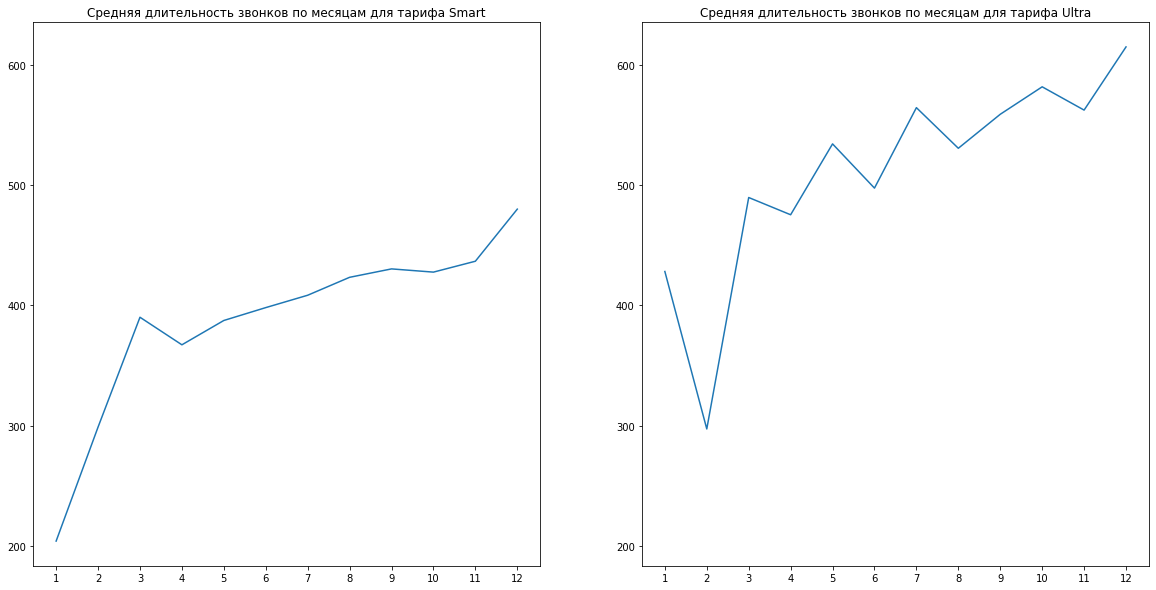

In [52]:
# Построение графиков средней длительности звонков разных тарифов по месяцам

# Создание фигуры для рисования
fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(1, 2, 2)
ax1 = fig.add_subplot(1, 2, 1, sharey = ax2) # Шарим ось Y графика Ultra для графика Smart для удобства анализа

# Построение графика средней длительности звонков по месяцам для тарифа Smart
ax1.plot(user_info[user_info['tariff'] == 'smart'][['1_call_duration',
                                                    '2_call_duration',
                                                    '3_call_duration',
                                                    '4_call_duration',
                                                    '5_call_duration',
                                                    '6_call_duration',
                                                    '7_call_duration',
                                                    '8_call_duration',
                                                    '9_call_duration',
                                                    '10_call_duration',
                                                    '11_call_duration',
                                                    '12_call_duration']].mean())

# Обозначения на оси X
ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Обозначение заголовка
ax1.set_title('Средняя длительность звонков по месяцам для тарифа Smart')

# Построение графика средней длительности звонков по месяцам для тарифа Ultra
ax2.plot(user_info[user_info['tariff'] == 'ultra'][['1_call_duration',
                                                    '2_call_duration',
                                                    '3_call_duration',
                                                    '4_call_duration',
                                                    '5_call_duration',
                                                    '6_call_duration',
                                                    '7_call_duration',
                                                    '8_call_duration',
                                                    '9_call_duration',
                                                    '10_call_duration',
                                                    '11_call_duration',
                                                    '12_call_duration']].mean())
# Обозначения на оси X
ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Обозначение заголовка
ax2.set_title('Средняя длительность звонков по месяцам для тарифа Ultra')

plt.show()

График средней длительности звонков для тарифа Smart выглядит более ровным. График для тарифа Ultra - более ломанный, но общий тренд длительности звонков у этого тарифа возрастает.

У тарифа Smart произошло небольшое падение показателя средней длительности звонков в апреле. В свою очередь, у тарифа Ultra наблюдается резкий спад в феврале, но уже в марте резкий подъем.

Логично, что значения показателей у тарифа Ultra значительно выше, чем у тарифа Smart. Но, возможно, такие высокие значения достигаются за счет нескольких пользователей, а все остальные тратят относительно мало минут. Проверим данное утверждение, рассчитав стандартное отклонение и построив гистограмму длительности звонков.

In [53]:
# Выборочное среднее длительности звонков по месяцам для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_call_duration',
                                           '2_call_duration',
                                           '3_call_duration',
                                           '4_call_duration',
                                           '5_call_duration',
                                           '6_call_duration',
                                           '7_call_duration',
                                           '8_call_duration',
                                           '9_call_duration',
                                           '10_call_duration',
                                           '11_call_duration',
                                           '12_call_duration']].mean().mean()

387.60580961751907

In [54]:
# Выборочное среднее длительности звонков по месяцам для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_call_duration',
                                           '2_call_duration',
                                           '3_call_duration',
                                           '4_call_duration',
                                           '5_call_duration',
                                           '6_call_duration',
                                           '7_call_duration',
                                           '8_call_duration',
                                           '9_call_duration',
                                           '10_call_duration',
                                           '11_call_duration',
                                           '12_call_duration']].mean().mean()

511.23471423122083

Как и говорилось ранее, выборочное среднее длительности звонков по месяцам у тарифа Ultra выше, чем у тарифа Smart. Проверим стандартное отклонение.

В методе `std()` укажем параметр `ddof=0`. Этот параметр учитывает поправку Бесселя. Она нужна, так как мы работаем с выборкой за 2018 год, а не со всей генеральной совокупностью данных.

In [55]:
# Вычисление стандартного отклонения каждого месяца для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_call_duration',
                                           '2_call_duration',
                                           '3_call_duration',
                                           '4_call_duration',
                                           '5_call_duration',
                                           '6_call_duration',
                                           '7_call_duration',
                                           '8_call_duration',
                                           '9_call_duration',
                                           '10_call_duration',
                                           '11_call_duration',
                                           '12_call_duration']].std(ddof=0)

1_call_duration     151.946417
2_call_duration     189.167888
3_call_duration     190.643469
4_call_duration     185.654753
5_call_duration     185.938458
6_call_duration     172.559304
7_call_duration     179.136318
8_call_duration     184.475510
9_call_duration     181.172038
10_call_duration    186.468371
11_call_duration    176.073505
12_call_duration    197.522112
dtype: float64

In [56]:
# Вычисление среднего стандартного отклонения для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_call_duration',
                                           '2_call_duration',
                                           '3_call_duration',
                                           '4_call_duration',
                                           '5_call_duration',
                                           '6_call_duration',
                                           '7_call_duration',
                                           '8_call_duration',
                                           '9_call_duration',
                                           '10_call_duration',
                                           '11_call_duration',
                                           '12_call_duration']].std(ddof=0).mean()

181.72984535231765

In [57]:
# Вычисление стандартного отклонения каждого месяца для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_call_duration',
                                            '2_call_duration',
                                            '3_call_duration',
                                            '4_call_duration',
                                            '5_call_duration',
                                            '6_call_duration',
                                            '7_call_duration',
                                            '8_call_duration',
                                            '9_call_duration',
                                            '10_call_duration',
                                            '11_call_duration',
                                            '12_call_duration']].std(ddof=0)

1_call_duration     254.330251
2_call_duration     290.269460
3_call_duration     329.202822
4_call_duration     254.540473
5_call_duration     271.497698
6_call_duration     291.475009
7_call_duration     293.197015
8_call_duration     300.473647
9_call_duration     312.585404
10_call_duration    310.349985
11_call_duration    296.249841
12_call_duration    327.376241
dtype: float64

In [58]:
# Вычисление среднего стандартного отклонения для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_call_duration',
                                           '2_call_duration',
                                           '3_call_duration',
                                           '4_call_duration',
                                           '5_call_duration',
                                           '6_call_duration',
                                           '7_call_duration',
                                           '8_call_duration',
                                           '9_call_duration',
                                           '10_call_duration',
                                           '11_call_duration',
                                           '12_call_duration']].std(ddof=0).mean()

294.2956537842227

Среднее стандартное отклонение длительности звонков для тарифа Ultra больше, чем для тарифа Smart. 

Проанализируем гистограмму длительности каждого звонка для двух тарифов.

Для построения гистограммы выполним следующие действия:

1. Присоединим к исходному датафрейму `calls` тариф каждого пользователя.

2. Создадим таблицу `calls_hist`, выполнив группировку по столбцам `user_id`, `tariff` и `call_month`.

3. Создадим таблицы `calls_hist_smart` и `calls_hist_ultra`, в которые попадут данные длительности звонков из таблицы `calls_hist` в зависимости от тарифа.

4. Построим гистограмму для каждой таблицы с достаточно большим количеством корзин.

In [59]:
# Присоединение тарифа к таблице call
calls = calls.merge(users[['user_id', 'tariff']], on = 'user_id', how = 'inner')

In [60]:
# Группировка данных по столбцам 'user_id', 'tariff' и 'call_month'
calls_hist = (
    calls
    .groupby(['user_id', 'tariff', 'call_month'])[['duration', 'tariff']]
    .agg('sum').reset_index()
)

In [61]:
# Создание общей таблицы длительности звонков помесячно для тарифа Smart 
calls_hist_smart = calls_hist[calls_hist['tariff'] == 'smart']['duration']

In [62]:
# Создание общей таблицы длительности звонков помесячно для тарифа Ultra
calls_hist_ultra = calls_hist[calls_hist['tariff'] == 'ultra']['duration']

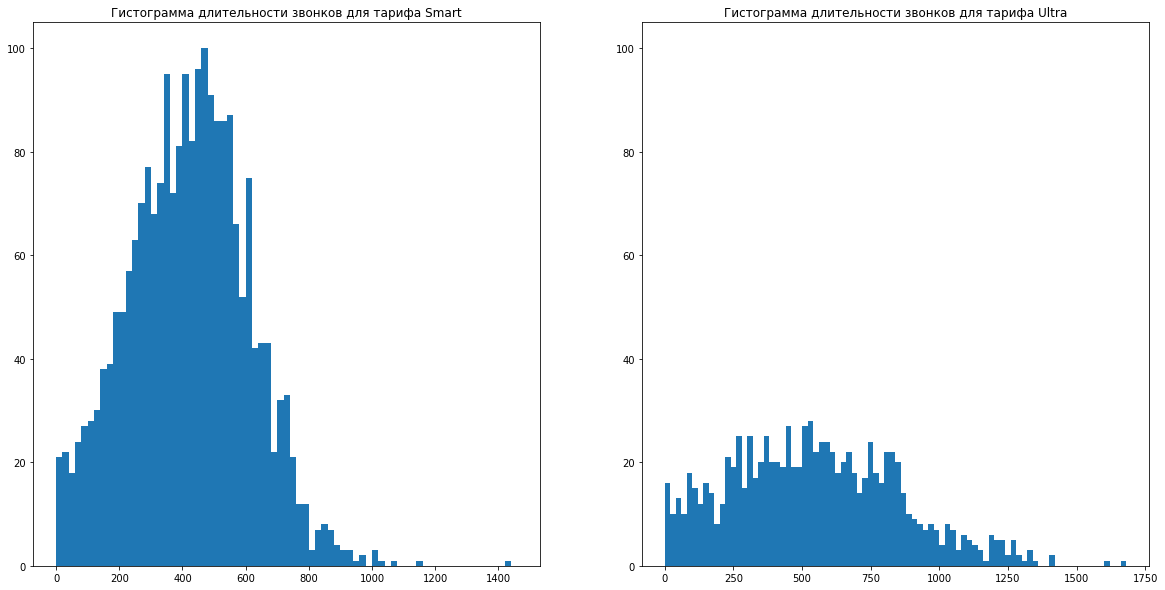

In [63]:
# Построение гистограмм длительности звонков по месяцам для разных тарифов

# Создание фигур для рисования
fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(1,2,2)
ax1 = fig.add_subplot(1,2,1, sharey = ax2)

# Построение гистограммы для тарифа Smart
ax1.hist(calls_hist_smart, bins = list(range(0, 1480, 20)))

# Построение гистограммы для тарифа Ultra
ax2.hist(calls_hist_ultra, bins = list(range(0, 1700, 20)))

# Обозначение заголовков
ax1.set_title('Гистограмма длительности звонков для тарифа Smart')
ax2.set_title('Гистограмма длительности звонков для тарифа Ultra')

plt.show()

Гистограммы для обоих тарифов напоминают нормальное распределение, смещенное вправо.

У тарифа Smart максимальная частота длительности звонков приходится на 420 минут и существует достаточно большое количество случаев выхода за пределы бесплатного лимита (500 минут). У тарифа Ultra максимальная частота использования - 520 и относительное малое количество выходов за пределы бесплатного лимита (1000 минут).

На гистограммах четко видно, что стандартное отклонение у тарифа Ultra действительно больше, так как "купол" графика выглядит шире.

Гистограммы показывают, что у тарифа Smart больше пользователей. 

Вывод, что тариф Smart приносит больше выручки за счет бОльшего количества пользователей и частые выходы за пределы бесплатного лимита делать пока рано. Потому что бОльшая цена на тариф Ultra и при меньшем количестве пользователей может приносить больше выгоды.

Теперь рассмотрим количество отправленных сообщений.

### Анализ статистик отправленных сообщений

In [64]:
# Вычисление среднего количества отправленных сообщений для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_messages_count',
                                           '2_messages_count',
                                           '3_messages_count',
                                           '4_messages_count',
                                           '5_messages_count',
                                           '6_messages_count',
                                           '7_messages_count',
                                           '8_messages_count',
                                           '9_messages_count',
                                           '10_messages_count',
                                           '11_messages_count',
                                           '12_messages_count']].mean()

1_messages_count     20.000000
2_messages_count     27.940000
3_messages_count     35.550725
4_messages_count     35.864583
5_messages_count     39.032787
6_messages_count     38.577465
7_messages_count     38.988506
8_messages_count     38.750000
9_messages_count     39.219731
10_messages_count    39.082677
11_messages_count    39.881481
12_messages_count    42.264808
dtype: float64

In [65]:
# Вычисление среднего количества отправленных сообщений для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_messages_count',
                                           '2_messages_count',
                                           '3_messages_count',
                                           '4_messages_count',
                                           '5_messages_count',
                                           '6_messages_count',
                                           '7_messages_count',
                                           '8_messages_count',
                                           '9_messages_count',
                                           '10_messages_count',
                                           '11_messages_count',
                                           '12_messages_count']].mean()

1_messages_count     43.428571
2_messages_count     32.937500
3_messages_count     47.800000
4_messages_count     44.512821
5_messages_count     48.769231
6_messages_count     52.313433
7_messages_count     62.136986
8_messages_count     58.897727
9_messages_count     63.294737
10_messages_count    69.776699
11_messages_count    66.159292
12_messages_count    72.008547
dtype: float64

<ipython-input-66-3d6b18634331>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
<ipython-input-66-3d6b18634331>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


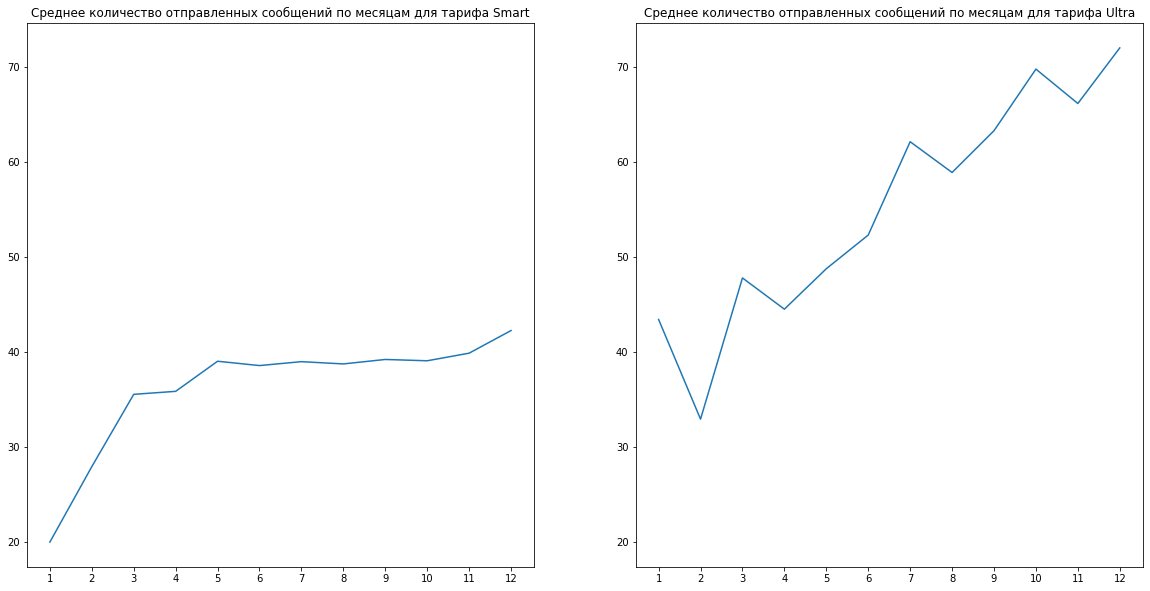

In [66]:
# Построение графиков среднего количества отправленных сообщений для разных тарифов по месяцам

fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(1, 2, 2)
ax1 = fig.add_subplot(1, 2, 1, sharey = ax2)

# Построение графика среднего количества отправленных сообщений по месяцам для тарифа Smart
ax1.plot(user_info[user_info['tariff'] == 'smart'][['1_messages_count',
                                                    '2_messages_count',
                                                    '3_messages_count',
                                                    '4_messages_count',
                                                    '5_messages_count',
                                                    '6_messages_count',
                                                    '7_messages_count',
                                                    '8_messages_count',
                                                    '9_messages_count',
                                                    '10_messages_count',
                                                    '11_messages_count',
                                                    '12_messages_count']].mean())
ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_title('Среднее количество отправленных сообщений по месяцам для тарифа Smart')

# Построение графика среднего количества отправленных сообщений по месяцам для тарифа Ultra
ax2.plot(user_info[user_info['tariff'] == 'ultra'][['1_messages_count',
                                                    '2_messages_count',
                                                    '3_messages_count',
                                                    '4_messages_count',
                                                    '5_messages_count',
                                                    '6_messages_count',
                                                    '7_messages_count',
                                                    '8_messages_count',
                                                    '9_messages_count',
                                                    '10_messages_count',
                                                    '11_messages_count',
                                                    '12_messages_count']].mean())
ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax2.set_title('Среднее количество отправленных сообщений по месяцам для тарифа Ultra')

plt.show()

Графики напоминают ту же форму, что и в предыдущем пункте. График для тарифа Smart более ровный с плавным ростом на протяжении всего периода наблюдения. График для тарифа Ultra более ломанный, но общий тренд у него также идет на увеличение.

У тарифа Smart, так же как и в предыдущем пункте, есть небольшой провал в апреле, а у тарифа Ultra - в феврале.

На всем периоде наблюдения среднее количество отправленных сообщений у тарифа Smart значительно меньше, чем у тарифа Ultra.

Рассмотрим значения выборочного среднего количества отправленных сообщений, а также стандартное отклонение для обоих тарифов.

In [67]:
# Вычисление выборочного среднего количества отправленных сообщений для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_messages_count',
                                           '2_messages_count',
                                           '3_messages_count',
                                           '4_messages_count',
                                           '5_messages_count',
                                           '6_messages_count',
                                           '7_messages_count',
                                           '8_messages_count',
                                           '9_messages_count',
                                           '10_messages_count',
                                           '11_messages_count',
                                           '12_messages_count']].mean().mean()

36.2627302785857

In [68]:
# Вычисление выборочного среднего количества отправленных сообщений для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_messages_count',
                                           '2_messages_count',
                                           '3_messages_count',
                                           '4_messages_count',
                                           '5_messages_count',
                                           '6_messages_count',
                                           '7_messages_count',
                                           '8_messages_count',
                                           '9_messages_count',
                                           '10_messages_count',
                                           '11_messages_count',
                                           '12_messages_count']].mean().mean()

55.169628669643124

Как и ожидалось, в тарифе Ultra пользователи отправляют в 1,5 раза больше сообщений, чем в тарифе Smart.

In [69]:
# Вычисление стандартного отклонения количества отправленных СМС для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_messages_count',
                                           '2_messages_count',
                                           '3_messages_count',
                                           '4_messages_count',
                                           '5_messages_count',
                                           '6_messages_count',
                                           '7_messages_count',
                                           '8_messages_count',
                                           '9_messages_count',
                                           '10_messages_count',
                                           '11_messages_count',
                                           '12_messages_count']].std(ddof=0)

1_messages_count     15.620499
2_messages_count     20.776342
3_messages_count     25.691896
4_messages_count     22.637828
5_messages_count     25.170219
6_messages_count     26.953357
7_messages_count     26.743565
8_messages_count     27.630639
9_messages_count     26.445327
10_messages_count    27.085114
11_messages_count    26.621921
12_messages_count    28.801851
dtype: float64

In [70]:
# Вычисление среднего стандартного отклонения количества отправленных сообщений для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_messages_count',
                                           '2_messages_count',
                                           '3_messages_count',
                                           '4_messages_count',
                                           '5_messages_count',
                                           '6_messages_count',
                                           '7_messages_count',
                                           '8_messages_count',
                                           '9_messages_count',
                                           '10_messages_count',
                                           '11_messages_count',
                                           '12_messages_count']].std(ddof=0).mean()

25.01487975563734

In [71]:
# Вычисление стандартного отклонения количества отправленных сообщений для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_messages_count',
                                           '2_messages_count',
                                           '3_messages_count',
                                           '4_messages_count',
                                           '5_messages_count',
                                           '6_messages_count',
                                           '7_messages_count',
                                           '8_messages_count',
                                           '9_messages_count',
                                           '10_messages_count',
                                           '11_messages_count',
                                           '12_messages_count']].std(ddof=0)

1_messages_count     25.611700
2_messages_count     25.861334
3_messages_count     41.876007
4_messages_count     37.042506
5_messages_count     39.109617
6_messages_count     43.666719
7_messages_count     46.483556
8_messages_count     44.721116
9_messages_count     43.436069
10_messages_count    49.020886
11_messages_count    47.216423
12_messages_count    48.401189
dtype: float64

In [72]:
# Вычисление среднего стандартного отклонения количества отправленных сообщений для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_messages_count',
                                           '2_messages_count',
                                           '3_messages_count',
                                           '4_messages_count',
                                           '5_messages_count',
                                           '6_messages_count',
                                           '7_messages_count',
                                           '8_messages_count',
                                           '9_messages_count',
                                           '10_messages_count',
                                           '11_messages_count',
                                           '12_messages_count']].std(ddof=0).mean()

41.03726012897372

При бОльших количествах отправленных сообщений стандартное отклонение у тарифа Ultra выше, чем у тарифа Smart.

Общее возрастание стандартного отклонения для обоих тарифов связано с ростом количества пользователей от месяца к месяцу. Следовательно, подключаются новые пользователи, которые отправляют отличное от среднего число сообщений.

Теперь проанализируем гистограмму отправленных сообщений. Гистограмму будем строить по такому же алгоритму, что и в предыдущем пункте.

In [73]:
# Присоединение тарифа к таблице messages
messages = messages.merge(users[['user_id', 'tariff']], on = 'user_id', how = 'inner')

In [74]:
# Группировка данных по столбцам 'user_id', 'tariff' и 'message_month'
messages_hist = (
    messages
    .groupby(['user_id', 'tariff', 'message_month'])['id']
    .agg('count').reset_index()
)

In [75]:
messages_hist.head(10)

,user_id,tariff,message_month,id
0,1000,ultra,5,22
1,1000,ultra,6,60
2,1000,ultra,7,75
3,1000,ultra,8,81
4,1000,ultra,9,57
5,1000,ultra,10,73
6,1000,ultra,11,58
7,1000,ultra,12,70
8,1002,smart,6,4
9,1002,smart,7,11


In [76]:
# Создание общей таблицы количества отправленных СМС для тарифа Smart 
messages_hist_smart = messages_hist[messages_hist['tariff'] == 'smart']['id']

In [77]:
# Создание общей таблицы количества отправленных СМС для тарифа Ultra 
messages_hist_ultra = messages_hist[messages_hist['tariff'] == 'ultra']['id']

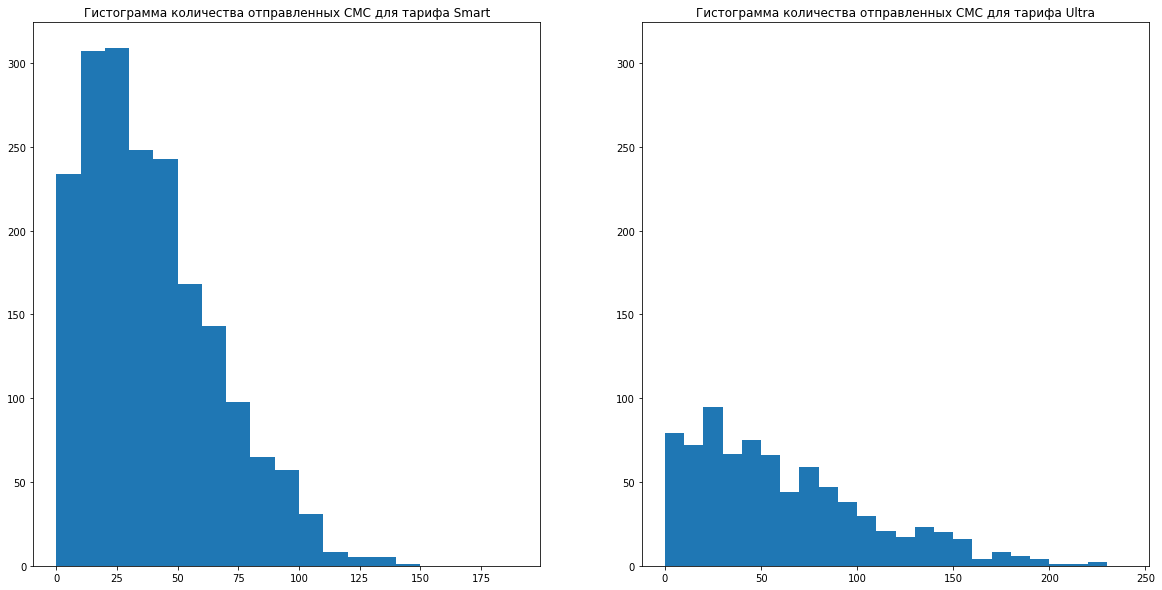

In [78]:
# Построение гистограмм количества отправленных СМС по месяцам для разных тарифов

# Создание фигур для рисования
fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(1,2,2)
ax1 = fig.add_subplot(1,2,1, sharey = ax2)

# Построение гистограммы для тарифа Smart
ax1.hist(messages_hist_smart, bins = list(range(0, 200, 10)))

# Построение гистограммы для тарифа Ultra
ax2.hist(messages_hist_ultra, bins = list(range(0, 250, 10)))


ax1.set_title('Гистограмма количества отправленных СМС для тарифа Smart')
ax2.set_title('Гистограмма количества отправленных СМС для тарифа Ultra')

plt.show()

Эти гистограммы уже меньше похожи на нормальное распределение. Они скорее напоминают распределение Пуассона. По определению это распределение представляет собой число событий, произошедших за фиксированное время, при условии, что данные события происходят с некоторой фиксированной средней интенсивностью и независимо друг от друга. Наш случай подходит под это определение. Мы действительно имеем случайное количество сообщений, отправляемых в пределах одного месяца.

По гистограммам видно, что стандартное отклонение у тарифа Ultra выше, чем у тарифа Smart.

Максимальная частота у тарифа Smart соответствует диапазону 10 - 30 сообщений. У тарифа Ultra - 30 сообщений.

Как и в предыдущем случае, у тарифа Smart достаточно много выходов за бесплатный лимит (50 сообщений). У тарифа Ultra вообще нет выходов за пределы бесплатного лимита (1000 сообщений). Следовательно, тариф Smart может получать дополнительную выручку (3 рубля за сообщение). В тарифе Ultra с большой долей вероятности это исключено.

### Анализ статистик потраченного интернет-трафика

In [79]:
# Вычисление среднего количества потраченного интернет-трафика для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_mb_sum',
                                           '2_mb_sum',
                                           '3_mb_sum',
                                           '4_mb_sum',
                                           '5_mb_sum',
                                           '6_mb_sum',
                                           '7_mb_sum',
                                           '8_mb_sum',
                                           '9_mb_sum',
                                           '10_mb_sum',
                                           '11_mb_sum',
                                           '12_mb_sum']].mean()

1_mb_sum      8513.717647
2_mb_sum     11597.054310
3_mb_sum     15104.159091
4_mb_sum     13462.180625
5_mb_sum     15805.184326
6_mb_sum     15794.647988
7_mb_sum     15743.150348
8_mb_sum     16681.706068
9_mb_sum     16303.578808
10_mb_sum    16757.122891
11_mb_sum    16895.696646
12_mb_sum    18113.662047
dtype: float64

In [80]:
# Вычисление среднего количества потраченного интернет-трафика для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_mb_sum',
                                           '2_mb_sum',
                                           '3_mb_sum',
                                           '4_mb_sum',
                                           '5_mb_sum',
                                           '6_mb_sum',
                                           '7_mb_sum',
                                           '8_mb_sum',
                                           '9_mb_sum',
                                           '10_mb_sum',
                                           '11_mb_sum',
                                           '12_mb_sum']].mean()

1_mb_sum     13140.681111
2_mb_sum     12846.477273
3_mb_sum     17535.550270
4_mb_sum     16828.134364
5_mb_sum     19656.534091
6_mb_sum     19152.950602
7_mb_sum     20723.394778
8_mb_sum     19760.734434
9_mb_sum     19372.735702
10_mb_sum    20209.643361
11_mb_sum    19935.585489
12_mb_sum    21951.094130
dtype: float64

<ipython-input-81-82adaa4c06bc>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
<ipython-input-81-82adaa4c06bc>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


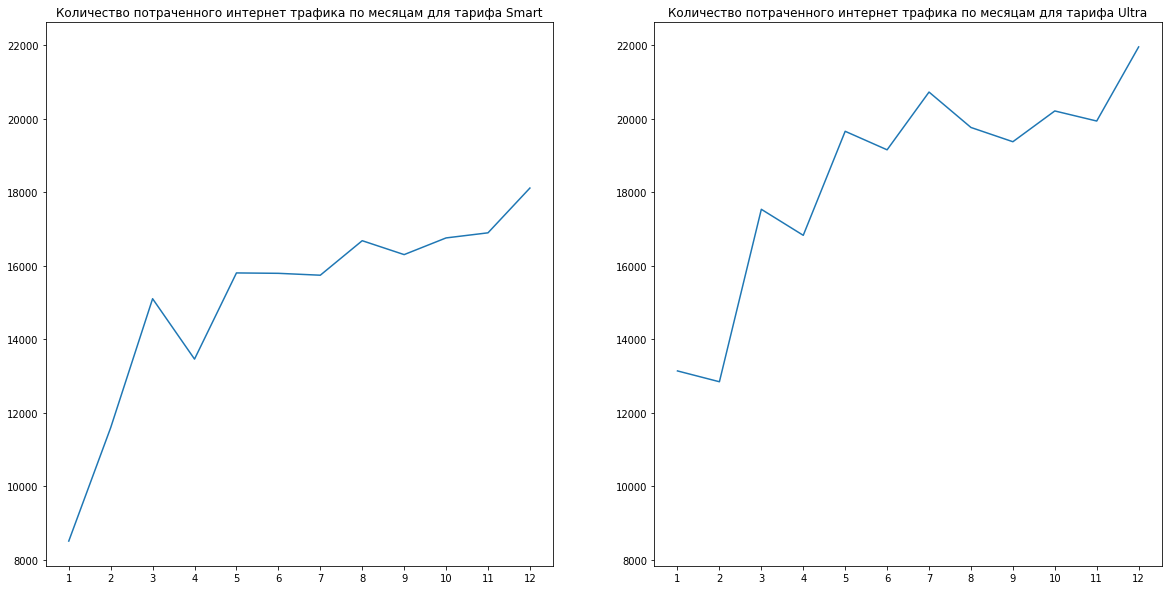

In [81]:
# Построение графиков среднего количества потраченного интернет-трафика для разных тарифов по месяцам

fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(1, 2, 2)
ax1 = fig.add_subplot(1, 2, 1, sharey = ax2)

# Построение графика среднего количества потраченного интернет-трафика по месяцам для тарифа Smart
ax1.plot(user_info[user_info['tariff'] == 'smart'][['1_mb_sum',
                                                    '2_mb_sum',
                                                    '3_mb_sum',
                                                    '4_mb_sum',
                                                    '5_mb_sum',
                                                    '6_mb_sum',
                                                    '7_mb_sum',
                                                    '8_mb_sum',
                                                    '9_mb_sum',
                                                    '10_mb_sum',
                                                    '11_mb_sum',
                                                    '12_mb_sum']].mean())
ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_title('Количество потраченного интернет трафика по месяцам для тарифа Smart')

# Построение графика среднего количества потраченного интернет-трафика по месяцам для тарифа Ultra
ax2.plot(user_info[user_info['tariff'] == 'ultra'][['1_mb_sum',
                                                    '2_mb_sum',
                                                    '3_mb_sum',
                                                    '4_mb_sum',
                                                    '5_mb_sum',
                                                    '6_mb_sum',
                                                    '7_mb_sum',
                                                    '8_mb_sum',
                                                    '9_mb_sum',
                                                    '10_mb_sum',
                                                    '11_mb_sum',
                                                    '12_mb_sum']].mean())
ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax2.set_title('Количество потраченного интернет трафика по месяцам для тарифа Ultra')

plt.show()

Ситуация схожая с предыдущим пунктом: средний объем интернет-трафика у тарифа Smart возрастает более плавно с провалом в апреле, у тарифа Ultra - более криво с провалом в феврале.

Начиная с марта, средний расход интернет-трафика у тарифа Smart превышает бесплатный лимит (15360 Мб). Возможно, у этого тарифа большое стандартное отклонение. Тогда высокое среднее достигается не всеми пользователями, а лишь несколькими, сильно выходящими за бесплатный лимит. Проверим это предположение, посчитав среднее отклонение и построив гистограммы.

In [82]:
# Вычисление среднего количества потраченного интернет-трафика для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_mb_sum',
                                           '2_mb_sum',
                                           '3_mb_sum',
                                           '4_mb_sum',
                                           '5_mb_sum',
                                           '6_mb_sum',
                                           '7_mb_sum',
                                           '8_mb_sum',
                                           '9_mb_sum',
                                           '10_mb_sum',
                                           '11_mb_sum',
                                           '12_mb_sum']].mean().mean()

15064.321732990802

In [83]:
# Вычисление выборочного среднего количества потраченного интернет-трафика для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_mb_sum',
                                           '2_mb_sum',
                                           '3_mb_sum',
                                           '4_mb_sum',
                                           '5_mb_sum',
                                           '6_mb_sum',
                                           '7_mb_sum',
                                           '8_mb_sum',
                                           '9_mb_sum',
                                           '10_mb_sum',
                                           '11_mb_sum',
                                           '12_mb_sum']].mean().mean()

18426.12630036421

Выборочное среднее тарифа Smart показывает, что множество пользователей тратят больше, чем отведено в бесплатном лимите. Значит, компания получает с интернет-трафика тарифа Smart дополнительную выручку. У тарифа Ultra небольшое количество пользователей, которые выходят за пределы бесплатного лимита (30720 Мб).

In [84]:
# Вычисление среднего количества потраченного интернет-трафика для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_mb_sum',
                                           '2_mb_sum',
                                           '3_mb_sum',
                                           '4_mb_sum',
                                           '5_mb_sum',
                                           '6_mb_sum',
                                           '7_mb_sum',
                                           '8_mb_sum',
                                           '9_mb_sum',
                                           '10_mb_sum',
                                           '11_mb_sum',
                                           '12_mb_sum']].std(ddof=0)

1_mb_sum     6349.198980
2_mb_sum     6193.263172
3_mb_sum     5790.268159
4_mb_sum     5672.753443
5_mb_sum     5956.994600
6_mb_sum     5773.472627
7_mb_sum     5882.466616
8_mb_sum     5486.626034
9_mb_sum     5186.113592
10_mb_sum    5849.411064
11_mb_sum    5331.816920
12_mb_sum    5565.406971
dtype: float64

In [85]:
# Вычисление среднего количества потраченного интернет-трафика для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_mb_sum',
                                           '2_mb_sum',
                                           '3_mb_sum',
                                           '4_mb_sum',
                                           '5_mb_sum',
                                           '6_mb_sum',
                                           '7_mb_sum',
                                           '8_mb_sum',
                                           '9_mb_sum',
                                           '10_mb_sum',
                                           '11_mb_sum',
                                           '12_mb_sum']].std(ddof=0).mean()

5753.149348121032

In [86]:
# Вычисление среднего количества потраченного интернет-трафика для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_mb_sum',
                                           '2_mb_sum',
                                           '3_mb_sum',
                                           '4_mb_sum',
                                           '5_mb_sum',
                                           '6_mb_sum',
                                           '7_mb_sum',
                                           '8_mb_sum',
                                           '9_mb_sum',
                                           '10_mb_sum',
                                           '11_mb_sum',
                                           '12_mb_sum']].std(ddof=0)

1_mb_sum      6472.711108
2_mb_sum     10232.602941
3_mb_sum     10802.775052
4_mb_sum      9629.893193
5_mb_sum      9754.869282
6_mb_sum      9054.859615
7_mb_sum      9827.963236
8_mb_sum     10300.913868
9_mb_sum      9312.484498
10_mb_sum     9632.260031
11_mb_sum     9756.693104
12_mb_sum    10210.012572
dtype: float64

In [87]:
# Вычисление среднего количества потраченного интернет-трафика для тарифа Smart
user_info[user_info['tariff'] == 'ultra'][['1_mb_sum',
                                           '2_mb_sum',
                                           '3_mb_sum',
                                           '4_mb_sum',
                                           '5_mb_sum',
                                           '6_mb_sum',
                                           '7_mb_sum',
                                           '8_mb_sum',
                                           '9_mb_sum',
                                           '10_mb_sum',
                                           '11_mb_sum',
                                           '12_mb_sum']].std(ddof=0).mean()

9582.336541685674

Достаточно малое стандартное отклонение тарифа Smart показывает, что действительно существует большое число пользователей, которые выходят за бесплатный лимит в течение месяца. Для полной уверенности проанализируем гистограмму частот потраченного интернет-трафика. Для более лаконичных результатов построим гистограмму для потраченных гигабайт, а не мегабайт, как в предыдущем случае.

In [88]:
# Присоединение тарифа к таблице internet
internet = internet.merge(users[['user_id', 'tariff']], on = 'user_id', how = 'inner')

In [89]:
# Группировка данных по столбцам 'user_id', 'tariff' и 'session_month'
internet_hist = (
    internet
    .groupby(['user_id', 'tariff', 'session_month'])['mb_used']
    .agg('sum')
    .reset_index()
)

In [90]:
# Округление потраченного интернет-трафика за месяц до Гб
internet_hist['gb_used'] = np.ceil(internet_hist['mb_used'] / 1024)

In [91]:
# Создание общей таблицы потраченного интернет-трафика помесячно для тарифа Smart 
internet_hist_smart = internet_hist[internet_hist['tariff'] == 'smart']['gb_used']

In [92]:
# Создание общей таблицы потраченного интернет-трафика помесячно для тарифа Ultra 
internet_hist_ultra = internet_hist[internet_hist['tariff'] == 'ultra']['gb_used']

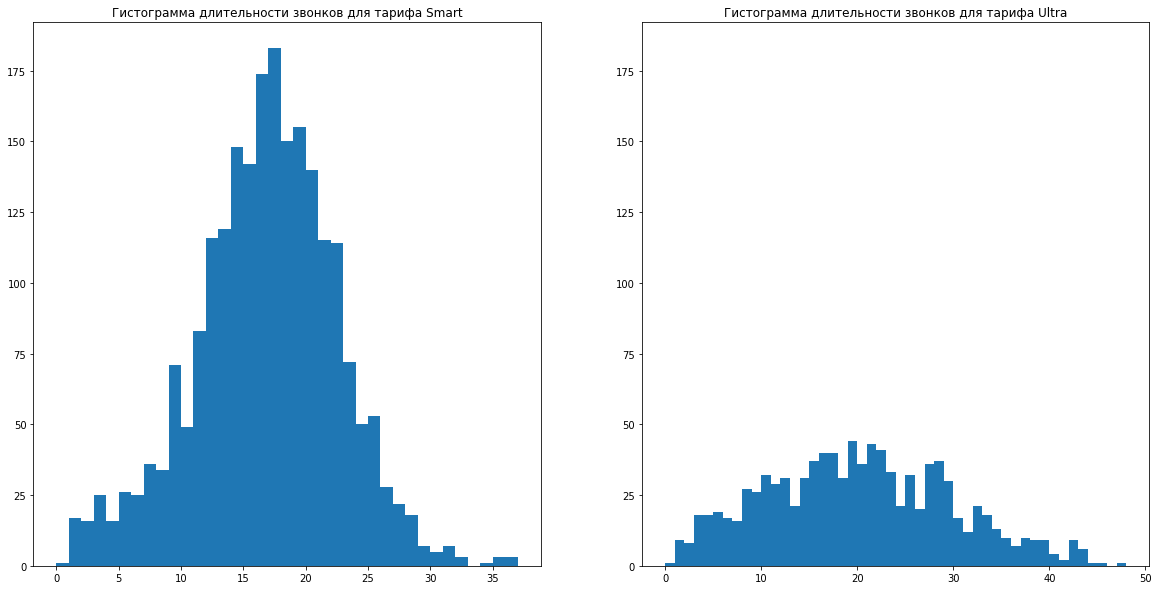

In [93]:
# Построение гистограмм потраченного интернет-трафика по месяцам для разных тарифов

# Создание фигур для рисования
fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(1,2,2)
ax1 = fig.add_subplot(1,2,1, sharey = ax2)

# Построение гистограммы для тарифа Smart
ax1.hist(internet_hist_smart, bins = list(range(0, 38)))

# Построение гистограммы для тарифа Ultra
ax2.hist(internet_hist_ultra, bins = list(range(0, 49)))


ax1.set_title('Гистограмма длительности звонков для тарифа Smart')
ax2.set_title('Гистограмма длительности звонков для тарифа Ultra')

plt.show()

Гистограммы частот снова напоминают нормальное распределение.

У тарифа Smart максимальная частота выпадает на значение 17 Гб, что уже превышает отведенный лимит. При этом, достаточно много пользователей, которые используют больше 17 Гб интернет-трифика. Следовательно, можем сделать вывод, что тариф Smart приносит большую дополнительную выручку (200 рублей за дополнительный Гб).

У тарифа Ultra максимальная частота выпадает на 19 Гб. Также существует небольшое число пользователей, которые выходят за пределы отведенного тарифа (30 Гб).

По гистограммам также видно, что у тарифа Smart меньше стандартное отклонение потраченного интернет-трафика.

Теперь перейдем к анализу выручки в разрезе обоих тарифов.

### Анализ статистик полученной выручки

Подведем итог анализа всех предыдущих пунктов, отталкиваясь от выручки.

Нам удалось выяснить, что тариф Smart рассчитан на большое количество пользователей за счет меньшей абоненткой платы за тариф. А также он рассчитан на получение дополнительной выручки, так как пользователи часто выходят за отведенные лимиты.

Тариф Ultra имеет стоимость почти в 4 раза превышающую стоимость тарифа Smart (1950 рублей и 550 рублей соответственно). Его использует меньшее количество пользователей и за пределы отведенных лимитов пользователи выходят редко. В стоимость этого тарифа уже заложено, что пользователи будут редко приносить дополнительную выручку.

Самый главный вопрос этого исследования: какой тариф приносит больше выручки?

На этот вопрос мы постараемся ответить в этом пункте.

In [94]:
# Вычисление средней выручки по месяцам для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_revenue',
                                           '2_revenue',
                                           '3_revenue',
                                           '4_revenue',
                                           '5_revenue',
                                           '6_revenue',
                                           '7_revenue',
                                           '8_revenue',
                                           '9_revenue',
                                           '10_revenue',
                                           '11_revenue',
                                           '12_revenue']].mean()

1_revenue      721.323529
2_revenue      827.603448
3_revenue     1164.623377
4_revenue      963.089286
5_revenue     1197.510638
6_revenue     1204.018293
7_revenue     1223.950249
8_revenue     1320.595745
9_revenue     1249.946154
10_revenue    1364.853741
11_revenue    1343.047468
12_revenue    1578.531157
dtype: float64

In [95]:
# Вычисление средней выручки по месяцам для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_revenue',
                                           '2_revenue',
                                           '3_revenue',
                                           '4_revenue',
                                           '5_revenue',
                                           '6_revenue',
                                           '7_revenue',
                                           '8_revenue',
                                           '9_revenue',
                                           '10_revenue',
                                           '11_revenue',
                                           '12_revenue']].mean()

1_revenue     1950.000000
2_revenue     1975.000000
3_revenue     2014.864865
4_revenue     2001.818182
5_revenue     2059.701493
6_revenue     2039.285714
7_revenue     2118.131868
8_revenue     2083.177570
9_revenue     2024.347826
10_revenue    2065.853659
11_revenue    2092.164179
12_revenue    2138.848921
dtype: float64

<ipython-input-96-c938fe3cfa71>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
<ipython-input-96-c938fe3cfa71>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


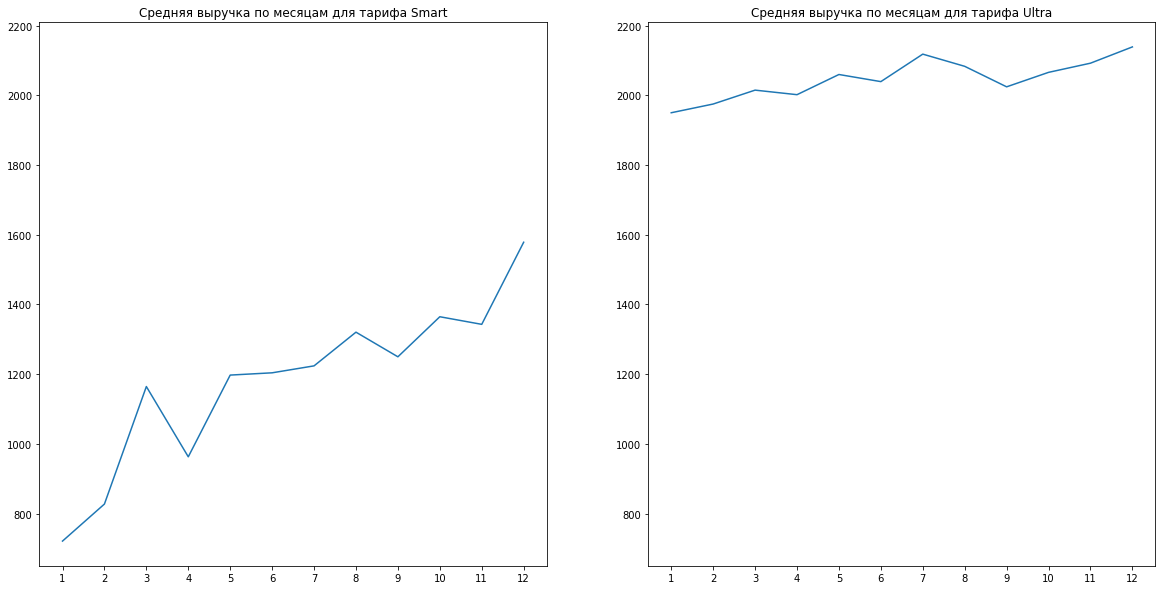

In [96]:
# Построение графиков средней выручки для разных тарифов по месяцам

fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(1, 2, 2)
ax1 = fig.add_subplot(1, 2, 1, sharey = ax2)

# Построение графика средней выручки по месяцам для тарифа Smart
ax1.plot(user_info[(user_info['tariff'] == 'smart')][['1_revenue',
                                                      '2_revenue',
                                                      '3_revenue',
                                                      '4_revenue',
                                                      '5_revenue',
                                                      '6_revenue',
                                                      '7_revenue',
                                                      '8_revenue',
                                                      '9_revenue',
                                                      '10_revenue',
                                                      '11_revenue',
                                                      '12_revenue']].mean())

# Построение графика средней выручки по месяцам для тарифа Ultra
ax2.plot(user_info[user_info['tariff'] == 'ultra'][['1_revenue',
                                                    '2_revenue',
                                                    '3_revenue',
                                                    '4_revenue',
                                                    '5_revenue',
                                                    '6_revenue',
                                                    '7_revenue',
                                                    '8_revenue',
                                                    '9_revenue',
                                                    '10_revenue',
                                                    '11_revenue',
                                                    '12_revenue']].mean())


ax1.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

ax1.set_title('Средняя выручка по месяцам для тарифа Smart')
ax2.set_title('Средняя выручка по месяцам для тарифа Ultra')


plt.show()

Средняя выручка тарифа Smart значительно меньше, чем выручка тарифа Ultra.

У тарифа Smart есть провал по выручке в апреле и, возможно, в рамках другого исследования этот момент стоит проанализировать более детально.

У тарифа Ultra наоборот, начиная с апреля происходит увеличение выручки, так как пользователей выходящих за отведенный лимит становится все больше. В предыдущих пунктах исследования у тарифа Ultra наблюдалось падение всех показателей в феврале, но на выручке это никак не сказалось.

Проанализируем все остальные статистики и построим гистограмму частот выручки.

In [97]:
# Вычисление выборочного среднего выручек для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_revenue',
                                           '2_revenue',
                                           '3_revenue',
                                           '4_revenue',
                                           '5_revenue',
                                           '6_revenue',
                                           '7_revenue',
                                           '8_revenue',
                                           '9_revenue',
                                           '10_revenue',
                                           '11_revenue',
                                           '12_revenue']].mean().mean()

1179.9244237841976

In [98]:
# Вычисление выборочного среднего выручек для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_revenue',
                                           '2_revenue',
                                           '3_revenue',
                                           '4_revenue',
                                           '5_revenue',
                                           '6_revenue',
                                           '7_revenue',
                                           '8_revenue',
                                           '9_revenue',
                                           '10_revenue',
                                           '11_revenue',
                                           '12_revenue']].mean().mean()

2046.9328563602276

Выборочное среднее нам демонстрирует, что выручка от тарифа Ultra почти в 2 раза больше, чем выручка от тарифа Smart.

In [99]:
# Вычисление стандартного отклонения выручек для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_revenue',
                                           '2_revenue',
                                           '3_revenue',
                                           '4_revenue',
                                           '5_revenue',
                                           '6_revenue',
                                           '7_revenue',
                                           '8_revenue',
                                           '9_revenue',
                                           '10_revenue',
                                           '11_revenue',
                                           '12_revenue']].std(ddof=0)

1_revenue      432.266035
2_revenue      536.020520
3_revenue      693.477648
4_revenue      559.549700
5_revenue      720.404857
6_revenue      743.460937
7_revenue      736.630927
8_revenue      790.536937
9_revenue      731.180077
10_revenue     841.338528
11_revenue     794.469663
12_revenue    1033.199594
dtype: float64

In [100]:
# Вычисление среднего стандартного отклонения для тарифа Smart
user_info[user_info['tariff'] == 'smart'][['1_revenue',
                                           '2_revenue',
                                           '3_revenue',
                                           '4_revenue',
                                           '5_revenue',
                                           '6_revenue',
                                           '7_revenue',
                                           '8_revenue',
                                           '9_revenue',
                                           '10_revenue',
                                           '11_revenue',
                                           '12_revenue']].std(ddof=0).mean()

717.7112851448829

In [101]:
# Вычисление стандартного отклонения выручек для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_revenue',
                                           '2_revenue',
                                           '3_revenue',
                                           '4_revenue',
                                           '5_revenue',
                                           '6_revenue',
                                           '7_revenue',
                                           '8_revenue',
                                           '9_revenue',
                                           '10_revenue',
                                           '11_revenue',
                                           '12_revenue']].std(ddof=0)

1_revenue       0.000000
2_revenue      82.915620
3_revenue     204.960400
4_revenue     194.460474
5_revenue     400.302013
6_revenue     314.062421
7_revenue     443.544445
8_revenue     397.829621
9_revenue     245.778728
10_revenue    385.315681
11_revenue    407.845380
12_revenue    480.558846
dtype: float64

In [102]:
# Вычисление среднего стандартного отклонения выручек для тарифа Ultra
user_info[user_info['tariff'] == 'ultra'][['1_revenue',
                                           '2_revenue',
                                           '3_revenue',
                                           '4_revenue',
                                           '5_revenue',
                                           '6_revenue',
                                           '7_revenue',
                                           '8_revenue',
                                           '9_revenue',
                                           '10_revenue',
                                           '11_revenue',
                                           '12_revenue']].std(ddof=0).mean()

296.46446911269925

Среднее стандартное отклонение у тарифа Smart больше, чем у тарифа Ultra. Это свидетельствует о неравномерном выходе за отведенные лимиты пользователями, следовательно, и об неравномерной выручке тарифа Smart. У тарифа Ultra пользователи очень редко выходят за пределы лимитов, поэтому выручка с пользователя почти всегда равна 1950 рублей.

Теперь построим гистограммы частот выручки в разрезе тарифов. Для построения гистограммы выполним конкатенацию 12-и столбцов выручки в один столбец датафрейма `revenue_list`.

Для того чтобы корректно передать столбцы выручки методу `concat` их необходимо выделить в отдельные датафреймы. Для разбивки по тарифам, в эти датафреймы также необходимо записать столбец `tarrif` из таблицы `user_info`. Для корректного соединения строк, получившиеся столбцы в датафреме необходимо переименовать одинаковыми названиями.

In [103]:
# Подготовка датафреймов, состоящих их столбцов выручки за определенный месяц и соответствующего тарифа

revenue_list_1 = user_info[['1_revenue', 'tariff']]
revenue_list_1 = revenue_list_1.rename(columns = {'1_revenue':'revenue'})
                                       
revenue_list_2 = user_info[['2_revenue', 'tariff']]
revenue_list_2 = revenue_list_2.rename(columns = {'2_revenue':'revenue'})
                                       
revenue_list_3 = user_info[['3_revenue', 'tariff']]
revenue_list_3 = revenue_list_3.rename(columns = {'3_revenue':'revenue'})

revenue_list_4 = user_info[['4_revenue', 'tariff']]
revenue_list_4 = revenue_list_4.rename(columns = {'4_revenue':'revenue'})

revenue_list_5 = user_info[['5_revenue', 'tariff']]
revenue_list_5 = revenue_list_5.rename(columns = {'5_revenue':'revenue'})

revenue_list_6 = user_info[['6_revenue', 'tariff']]
revenue_list_6 = revenue_list_6.rename(columns = {'6_revenue':'revenue'})

revenue_list_7 = user_info[['7_revenue', 'tariff']]
revenue_list_7 = revenue_list_7.rename(columns = {'7_revenue':'revenue'})

revenue_list_8 = user_info[['8_revenue', 'tariff']]
revenue_list_8 = revenue_list_8.rename(columns = {'8_revenue':'revenue'})

revenue_list_9 = user_info[['9_revenue', 'tariff']]
revenue_list_9 = revenue_list_9.rename(columns = {'9_revenue':'revenue'})

revenue_list_10 = user_info[['10_revenue', 'tariff']]
revenue_list_10 = revenue_list_10.rename(columns = {'10_revenue':'revenue'})

revenue_list_11 = user_info[['11_revenue', 'tariff']]
revenue_list_11 = revenue_list_11.rename(columns = {'11_revenue':'revenue'})

revenue_list_12 = user_info[['12_revenue', 'tariff']]
revenue_list_12 = revenue_list_12.rename(columns = {'12_revenue':'revenue'})

# Так как concat принимает максимум 10 датафреймов, а нам надо 12, запишем эти датафреймы в список 
frames = [revenue_list_1,
          revenue_list_2,
          revenue_list_3,
          revenue_list_4,
          revenue_list_5,
          revenue_list_6,
          revenue_list_7,
          revenue_list_8,
          revenue_list_9,
          revenue_list_10,
          revenue_list_11,
          revenue_list_12]

# Выполнение конкатенации столбцов выручки в один столбец
revenue_list = pd.concat(frames, axis=0, ignore_index=True)

Все готово для построения гистограмм.

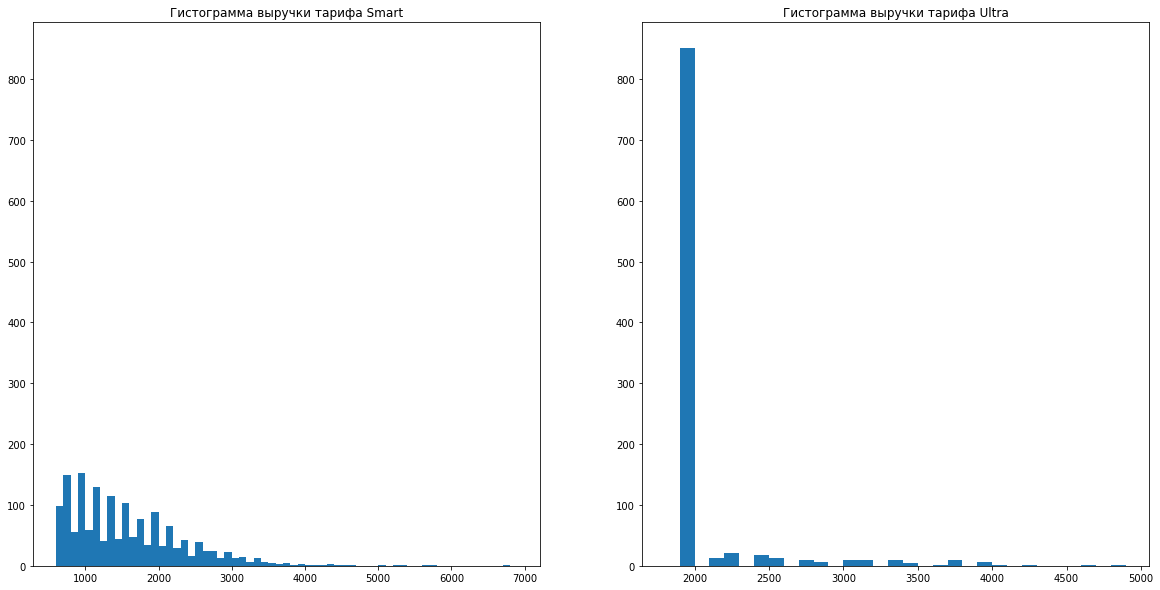

In [104]:
# Созадние фигуры и сабплотов на ней
fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(1, 2, 2)
ax1 = fig.add_subplot(1, 2, 1, sharey = ax2)

# Построение гистограммы выручки для тарифа Smart
ax1.hist(revenue_list[revenue_list['tariff'] == 'smart']['revenue'], bins = list(range(600, 7000, 100)))

# Построение гистограммы выручки для тарифа Smart
ax2.hist(revenue_list[revenue_list['tariff'] == 'ultra']['revenue'], bins = list(range(1800, 5000, 100)))

# Присвоение заголовков
ax1.set_title('Гистограмма выручки тарифа Smart')
ax2.set_title('Гистограмма выручки тарифа Ultra')

plt.show()

Гистограммы снова наминают распределение Пуассона.

У тарифа Ultra больше пользователей, которые платят строго определенную цену за услуги, чем у тарифа Smart (более 800 раз пользователи заплатили 1950 рублей). Как мы уже ранее говорили, это связано с тем, что пользователи тарифа Ultra редко выходят за отведенные лимиты, следовательно, они редко переплачивают установленную стоимость тарифа.

У тарифа Smart плата за услуги сильно ранжируется, однако существует множество пользователей, которые тратят более 2000 рублей. Однако среднее показывает, что этого недостаточно, чтобы сравниться по выручке с тарифом Ultra.

Гистограммы доказывают, что стандартное отклонение у тарифа Smart больше, чем у тарифа Ultra.

Гистограммы также доказывают предыдущие вычисления: в исходных выборках средняя выручка у тарифа Ultra больше, чем  у тарифа Smart.

## Проверка гипотез

### Проверка гипотезы о равенстве средних выручек тарифов Smart и Ultra

В прошлом пункте исследования мы сделали вывод о выручке, исходя из выборки. Однако, вдруг в генеральной совокупности выручка пользоватлей из обоих тарифов равны друг другу. Проверим эту гипотезу с помощью математической статистически.

Выдвинем нулевую гипотезу: средняя выручка пользователей тарифов Ultra и Smart равны.

Тогда альтернативная гипотеза будет звучать так: средняя выручка пользователей тарифов Ultra и Smart не равны.

Выполним проверку гипотезы с помощью метода `ttest_ind()` библиотеки `scipy`. Этот метод позволяет определить вероятность равенства средних двух выборок при условии того, что гипотеза верна. Пороговый уровень значимости будем считать за 1%, так как ранее на выборках мы уже определяли, что выборочное среднее двух тарифов отличается друг от друга практически в 2 раза. По такому результату можно считать успехом, если рассчитанная вероятность будет больше 1%.

Чтобы корректно передать выручку 2-х тарифов, преобразуем их в списки `revenue_smart` и `revenue_ultra`.

Ранее мы обнаружили, что стандартные отклонения выборок 2-х тарифов сильно отличаются. Поэтому в методе `ttest_ind()` выставим параметр `equal_var` равный False. Это позволит оценить дисперсию 2-x выборок отдельно друг от друга.

In [105]:
# Запись выручки тарифа Smart в отдельный список
revenue_smart = list(revenue_list[(revenue_list['tariff'] == 'smart') &
                                  ~(revenue_list['revenue'].isna())]['revenue'])

In [106]:
# Запись выручки тарифа Ultra в отдельный список
revenue_ultra = list(revenue_list[(revenue_list['tariff'] == 'ultra') &
                                  ~(revenue_list['revenue'].isna())]['revenue'])

In [107]:
# Среднее значение в списке revenue_smart
sum(revenue_smart) / len(revenue_smart)

1289.9735307312696

In [108]:
# Среднее значение в списке revenue_ultra
sum(revenue_ultra) / len(revenue_ultra)

2070.1522842639592

In [109]:
# Разница между средними
sum(revenue_ultra) / len(revenue_ultra) - sum(revenue_smart) / len(revenue_smart)

780.1787535326896

In [110]:
# Определение вероятности равенства средних тарифов Smart и Ultra
result = st.ttest_ind(revenue_smart, revenue_ultra, equal_var = False)
print('p-значение:', result.pvalue)
if (result.pvalue < 0.01):
    print('Отвергаем гипотезу')
else:
    print('Не отвергаем гипотезу')

p-значение: 4.2606313931076085e-250
Отвергаем гипотезу


Вероятность получить такое или еще большее различие между средней выручкой тарифа Smart и средней выручкой тарифа Ultra сильно меньше 1%. Поэтому есть основания отклонить нулевую гипотезу и принять альтернативную.

### Проверка гипотезы о равенстве средней выручки пользователей из Москвы и других регионов

В этом пункте проверим гипотезу о равенстве средней выручки пользователей из Москвы и других регионов.

Нулевая гипотеза будет звучать так: Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

Альтернативная гипотеза: Средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.

Для формирования необходимых списков выручки в зависимости от региона присоединим к таблице `user_info` столбец `city` из датафрейма `users`. После этого сделаем те же действия, что и в пункте 1.4.4, то есть создадим 12 датафреймов для метода `concat`. Далее объединим эти датафреймы в один и получим список в формате выручка - город. Далее сформируем списки `revenue_moscow` и `revenue_other_regions`, в которых будет перечислена выручка из Москвы и других регионов соответственно.

In [111]:
# Присоединение столбца city к датафрейму user_info
user_info = user_info.merge(users[['user_id', 'city']], on = 'user_id', how = 'left')

In [112]:
# Подготовка датафреймов, состоящих их столбцов выручки за определенный месяц и соответствующего города
revenue_list_1 = user_info[['1_revenue', 'city']]
revenue_list_1 = revenue_list_1.rename(columns = {'1_revenue':'revenue'})
                                       
revenue_list_2 = user_info[['2_revenue', 'city']]
revenue_list_2 = revenue_list_2.rename(columns = {'2_revenue':'revenue'})
                                       
revenue_list_3 = user_info[['3_revenue', 'city']]
revenue_list_3 = revenue_list_3.rename(columns = {'3_revenue':'revenue'})

revenue_list_4 = user_info[['4_revenue', 'city']]
revenue_list_4 = revenue_list_4.rename(columns = {'4_revenue':'revenue'})

revenue_list_5 = user_info[['5_revenue', 'city']]
revenue_list_5 = revenue_list_5.rename(columns = {'5_revenue':'revenue'})

revenue_list_6 = user_info[['6_revenue', 'city']]
revenue_list_6 = revenue_list_6.rename(columns = {'6_revenue':'revenue'})

revenue_list_7 = user_info[['7_revenue', 'city']]
revenue_list_7 = revenue_list_7.rename(columns = {'7_revenue':'revenue'})

revenue_list_8 = user_info[['8_revenue', 'city']]
revenue_list_8 = revenue_list_8.rename(columns = {'8_revenue':'revenue'})

revenue_list_9 = user_info[['9_revenue', 'city']]
revenue_list_9 = revenue_list_9.rename(columns = {'9_revenue':'revenue'})

revenue_list_10 = user_info[['10_revenue', 'city']]
revenue_list_10 = revenue_list_10.rename(columns = {'10_revenue':'revenue'})

revenue_list_11 = user_info[['11_revenue', 'city']]
revenue_list_11 = revenue_list_11.rename(columns = {'11_revenue':'revenue'})

revenue_list_12 = user_info[['12_revenue', 'city']]
revenue_list_12 = revenue_list_12.rename(columns = {'12_revenue':'revenue'})

# Так как concat принимает максимум 10 датафреймов, а нам надо 12, запишем эти датафреймы в список 
frames = [revenue_list_1,
          revenue_list_2,
          revenue_list_3,
          revenue_list_4,
          revenue_list_5,
          revenue_list_6,
          revenue_list_7,
          revenue_list_8,
          revenue_list_9,
          revenue_list_10,
          revenue_list_11,
          revenue_list_12]

# Выполнение конкатенации столбцов выручки в один столбец
revenue_list = pd.concat(frames, axis=0, ignore_index=True)

In [113]:
revenue_list

,revenue,city
0,NaN,Краснодар
1,NaN,Москва
2,NaN,Стерлитамак
3,NaN,Москва
4,NaN,Новокузнецк
...,...,...
5971,1950.0,Калуга
5972,2250.0,Чебоксары
5973,3300.0,Мурманск
5974,1950.0,Красноярск


In [114]:
# Запись выручки пользователей из Москвы в отдельный список
revenue_moscow = list(revenue_list[(revenue_list['city'] == 'Москва') &
                                  ~(revenue_list['revenue'].isna())]['revenue'])

In [115]:
# Запись выручки пользователей из других регионов в отдельный список
revenue_other_regions = list(revenue_list[(revenue_list['city'] != 'Москва') &
                                  ~(revenue_list['revenue'].isna())]['revenue'])

Списки готовы! Теперь можем перейти к методу `ttest_ind`, который помимо списков принимает параметр `equal_var`. Для корректности заполнения этого параметра посчитаем дисперсию двух выборок и посмотрим, соответствуют ли они друг другу.

In [116]:
# Подсчет дисперсии выборки revenue_moscow
np.var(revenue_moscow)

564710.7117467273

In [117]:
# Подсчет дисперсии выборки revenue_other_regions
np.var(revenue_other_regions)

653886.3270894174

In [118]:
# Среднее значение в списке revenue_moscow
sum(revenue_moscow) / len(revenue_moscow)

1546.7135842880523

In [119]:
# Среднее значение в списке revenue_other_regions
sum(revenue_other_regions) / len(revenue_other_regions)

1524.9362274298885

In [120]:
# Разница между средними значениями
sum(revenue_moscow) / len(revenue_moscow) - sum(revenue_other_regions) / len(revenue_other_regions)

21.777356858163785

В этом случае возьмем критерий значимости равный 5%. 

In [121]:
# Определение вероятности равенства средних выручек из Москвы и других регионов
result = st.ttest_ind(revenue_moscow, revenue_other_regions, equal_var = False)
print('p-значение:', result.pvalue)
if (result.pvalue < 0.05):
    print('Отвергаем гипотезу')
else:
    print('Не отвергаем гипотезу')

p-значение: 0.5257376663729298
Не отвергаем гипотезу


Вероятность получить такое или еще большее различие между средней выручкой от пользователей из Москвы и выручкой от пользователей из других регионов намного выше, чем уровень статистической значимости (5%). Нет оснований отвергать нулевую гипотезу.

## Вывод

В рамках этого исследования были сделаны следующие выводы:

1. Тарифом Smart пользуется бОльшее количество пользователей за счет более дешевой абонентской платы. Также этот тариф приносит высокую дополнительную выручку за счет регулярных выходов за отведенные лимиты.

2. Лимиты у тарифа Ultra устроены так, что за них выходит небольшой процент пользователей. За счет его высокой стоимости им пользуются меньше пользователей, чем тарифом Smart, но при этом он приносит больше средней выручки.

3. Вероятность получить 780 или еще большее различие между средней выручкой тарифа Smart (1290) и средней выручкой тарифа Ultra (2070) сильно меньше 1%. Поэтому есть основания отклонить нулевую гипотезу и принять альтернативную о том, что средняя выручка тарифа Smart и средняя выручка тарифа Ultra не равны.

4. Вероятность получить 21 или еще большее различие между средней выручкой от пользователей из Москвы (1546.71) и выручкой от пользователей из других регионов (1524.93) намного выше, чем уровень статистической значимости (5%). Поэтому нет оснований отвергать нулевую гипотезу о том, средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.